# Setup

In [1]:
!pwd

/home/umni2/a/umnilab/users/verma99/mk/home_detection/code


In [2]:
from setup import *

In [3]:
import haversine as hs
from haversine import haversine_vector as haversine
from sklearn.cluster import MeanShift

In [4]:
SP.start()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


23/03/29 21:58:20 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
23/03/29 21:58:20 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


## Load regions

In [5]:
indy = Region.load('Indianapolis', 'Indiana')
indy.dates = U.dates('2021-03-01', '2021-03-07')

In [6]:
aus = Region.load('Austin', 'Texas')
aus.dates = U.dates('2021-07-01', '2021-07-07')

In [7]:
hous = Region.load('Houston', 'Texas')
hous.dates = U.dates('2021-07-01', '2021-07-07')

In [8]:
rgns = [indy, aus, hous]

## Explore trajectories

In [9]:
d1 = (pd.read_parquet(aus.data / 'pings/2021-07-01')
      .pipe(lambda df: df[df[LON].apply(len) > 20])).disp()

77,834 rows x 5 cols; Memory: 36.8 MiB


,uid,lon,lat,ts,error
,<int64>,<object>,<object>,<object>,<object>
8,-9196759001762169042,"[-97.55725, -97.55725, -97.55725, -97.55725, -...","[30.52732, 30.52732, 30.52732, 30.52732, 30.52...","[52385.0, 52386.0, 52391.0, 52393.0, 52394.0, ...","[6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, ..."


In [10]:
r = d1.sample(random_state=125).iloc[0]

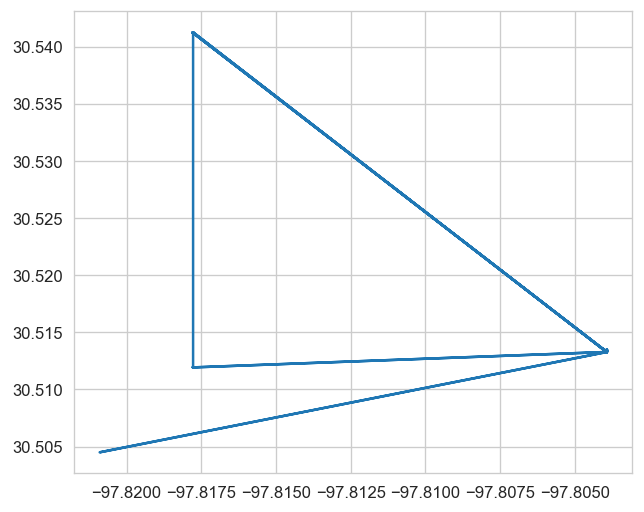

In [11]:
ax = U.plot(size=(6, 5), dpi=120)
ax.plot(r.lon, r.lat)
# for i in [10,142,143]:
#     ax.scatter(r.lon[i], r.lat[i], s=10, color='r')
#     ax.text(r.lon[i], r.lat[i], str(i))

# Prepare trips: Method 1 (old): Clustering

## Parameters

In [12]:
# minimum time (in seconds) required for a region to be considered stay region
min_dwell = 15*60 # 15 minutes
# bandwidth parameter for MeanShift clustering
cluster_radius = 250 # meters
# parameters for MeanShift clustering
ms_params = dict(bin_seeding=True, min_bin_freq=1, max_iter=30, cluster_all=False)

## Define methods

In [13]:
def dist_m2deg(dist, lat, a=6_371_001, b=6_356_752):
    lat = np.deg2rad(lat)
    curve_radius = (a * b) ** 2 / (
            (a * np.cos(lat)) ** 2 + (b * np.sin(lat)) ** 2) ** 1.5
    return float(np.rad2deg(dist / curve_radius))

In [14]:
def udf_segment_trips(lon, lat, ts, min_dwell, radius, **ms_kwargs):
    # convert the trajectory's coordinates to long format and sort by time
    df = pd.DataFrame({LON: lon, LAT: lat, TS: ts}).sort_values(TS)
    # compute kernel bandwidth in degrees from the kernel radius
    bandwidth = dist_m2deg(radius, df[LAT].mean())
    try:
        # create and fit a MeanShift model with the (x, y) coordinate data
        model = MeanShift(bandwidth=bandwidth, **ms_kwargs)
        with warnings.catch_warnings():
            warnings.simplefilter('ignore')
            model.fit(df[[LON, LAT]])
            # extract the cluster labels and centers
            df['label'] = model.labels_
            df[['cx', 'cy']] = model.cluster_centers_[df['label']]
    except ValueError:
        # in case of any error, return an empty table with the expected schema
        return []
    # redefine the clusters to make sure that temporally distant but
    # spatially close points are recognized as different clusters
    df['cid'] = (df['label'].diff() != 0).astype('int').cumsum()
    # get earliest & latest ping time of each redefined cluster
    C = df.groupby('cid')[TS].agg(['first', 'last'])
    # label the regions as stay/enroute based on their stay duration (seconds)
    C['enroute'] = C['last'] - C['first'] < min_dwell
    # join the cluster labels to the ping table
    df = df.merge(C['enroute'], on='cid')
    # collect ping points (x, y, t) for each cluster (row) in lists
    df['xyt'] = list(zip(df[LON], df[LAT], df[TS]))
    C = df.groupby(['cid', 'enroute'])['xyt'].agg(list).reset_index()
    # set same cluster IDs for consecutive enroute regions
    C['rgn_id'] = (((C['cid'] * (1 - C['enroute'].astype(int))).diff() != 0)
                   .astype(int).cumsum())
    # collect (combine) the points of consecutive enroute regions
    C = C.groupby(['rgn_id', 'enroute'])['xyt'].sum().reset_index()
    # identify trips & their ping coordinates from the stay/enroute
    # region data using the logic used in the Maputo report (p.47)
    trip_started = True
    trip_num = 0
    X, trips = [], []
    # for each virtual region (row)
    for enroute, xyt in zip(C['enroute'], C['xyt']):
        if enroute:  # if this is a non-stay (enroute) region
            if not trip_started:
                # add all points of the enroute region to the trip
                X += xyt
        else:  # if this is a stay region
            # if region's last point starts a new trip
            if trip_started:
                trip_started = enroute
                # add the last point of this region to the trip
                X.append(xyt[-1])
            else:  # if this region's first point ends the current trip
                # add the first point of this region to the trip
                X.append(xyt[0])
                # collect the points for this trip
                trips.append({'trip_num': trip_num} |
                             dict(zip([LON, LAT, TS], list(zip(*X)))))
                # create a new trip starting with this region's last point
                trip_num += 1
                X = [xyt[-1]]
    # return the segmented trips for this user-day
    return trips

# %time x = udf_segment_trips(r.lon, r.lat, r.ts, min_dwell, cluster_radius, **ms_params); x

## Main

In [15]:
def extract_trips_old(rgn, dates=None, min_dwell=min_dwell, 
                      cluster_radius=cluster_radius,
                      ms_params=ms_params):
    schema = T.array(mk.spark.schema({
        'trip_num': T.int16, LON: T.array(T.float),
        LAT: T.array(T.float), TS: T.array(T.float)}))
    for date in tqdm(dates or rgn.dates):
        U.log(f'started {date}')
        df = SP.read_parquet(rgn.data / f'pings/{date}')
        # df = df.limit(50)
        df = df.select(UID, F.udf(
            lambda lon, lat, ts: segment_trips_clustering(
                lon, lat, ts, min_dwell, cluster_radius, **ms_params),
            schema)(LON, LAT, TS).alias('trips'))
        df = df.select(UID, F.explode('trips').alias('trip'))
        df = df.select(UID, *[F.col('trip')[x].alias(x) 
                              for x in ['trip_num', LON, LAT, TS]])
        mk.spark.write(df, rgn.data / f'trips/{date}')    

In [16]:
# %time extract_trips_old(indy) # t=???
# %time extract_trips_old(aus) # t=???
# %time extract_trips_old(hous) # t=???

# Prepare trips: Method 2: Stay point-based
Algorithm based on the stay point detection algorithm of Li et al. (2008) (https://doi.org/10.1145/1463434.1463477), as used in Sadeghinasr et al. (2019) (https://doi.org/10.1061/9780784482438.002).

## Parameters

In [12]:
dist_thresh = 200 # meters
time_thresh = 30 # minutes
# min points in a user's all-time trajectory required for trip segmentation
min_pts = 10

## Define methods

In [13]:
def get_stay_point_trips(x, y, t, dist_thresh=200, time_thresh=30):
    """ Documentation in `mk.trips.get_stay_point_trips()` """
    trips, cur_trip = [], []
    trip_started = False
    i = 0
    while i < len(x):
        j = i + 1
        while j < len(x):
            dist = float(hs.haversine((y[i], x[i]), (y[j], x[j]), unit='m'))
            tdiff = (t[j] - t[i]) / 60
            if dist > dist_thresh:
                if tdiff > time_thresh:
                    coord = [sum(a[i:j])/(j-i) for a in [x, y]]
                    if trip_started:
                        cur_trip.append((*coord, t[i]))
                        trips.append(cur_trip)
                        cur_trip = []
                        trip_started = False
                    if not trip_started:
                        trip_started = True
                        cur_trip.append((*coord, t[j-1]))
                else:
                    if trip_started:
                        cur_trip.append((x[j], y[j], t[j]))
                i = j
                break
            j += 1
        if j == len(x):
            if trip_started:
                cur_trip.append((x[j-1], y[j-1], t[j-1]))
            break
    return trips

## Main

In [14]:
def extract_trips(rgn, dates=None, dist_thresh=dist_thresh,
                  time_thresh=time_thresh, min_pts=min_pts, save=False):
    df = []
    dates = dates or rgn.dates
    for date in dates:
        n_days = (date - dates[0]).days
        df2 = SP.read_parquet(rgn.data / f'pings/{date}')
        def add_day(t): return [t + n_days * 86400 for t in t]
        df2 = df2.withColumn(TS, F.udf(add_day, T.array(T.float))(TS))
        df.append(df2.select(UID, LON, LAT, TS))
    df = reduce(Sdf.union, df)
    df = df.groupby(UID).agg(*[F.flatten(F.collect_list(x)).alias(x) 
                               for x in [LON, LAT, TS]])
    df = df.filter(F.size(LON) >= min_pts)
    df = df.withColumn('trips', F.udf(
        lambda x, y, t: get_stay_point_trips(
            x, y, t, dist_thresh, time_thresh), 
        T.array(T.array(T.array(T.float))))(LON, LAT, TS))
    df = df.select(UID, F.explode('trips').alias('trip'))
    df = df.select(UID, *[F.udf(lambda x: [y[i] for y in x], 
                                T.array(T.float))('trip').alias(x) 
                          for i, x in enumerate([LON, LAT, TS])])
    if save:
        mk.spark.write(df, rgn.data / f'trips/A3')
    return df
        
x = extract_trips(indy); x

DataFrame[uid: bigint, lon: array<float>, lat: array<float>, ts: array<float>]

In [15]:
# %time extract_trips(indy, save=True) # t=1:07
# %time extract_trips(aus, save=True) # t=41s
# %time extract_trips(hous, save=True) # t=1:56

## [Temporary] Trips for Xiaowei's work

In [26]:
def extract_trips_xiaowei(
    dates=U.dates('2021-03-01', '2021-03-31'),
    minx=-87.029979, miny=40.345157,
    maxx=-86.733146, maxy=40.505030,
    min_pts=10,
    time_thresh=5*60,
    dist_thresh=100,
    # max_speed=60,
):
    df = []
    for date in dates:
        n_days = (date - dates[0]).days
        df2 = SP.read_parquet(QUADRANT / (
            'Indiana/' + date.strftime('%Y/%m/%d')))
        def add_day(t): return [t + n_days * 86400 for t in t]
        df2 = df2.withColumn(TS, F.udf(add_day, T.array(T.float))(TS))
        df.append(df2.select(UID, LON, LAT, TS))
    df = reduce(Sdf.union, df)
    df = mk.gps.zip_pings(df, 'pts')
    df = df.withColumn('pts', F.udf(lambda pts: list(zip(*[
        tuple(p) for p in pts if
        minx <= p[0] <= maxx and miny <= p[1] <= maxy
    ])), T.array(T.array(T.float)))('pts'))
    df = (df.groupby(UID)
          .agg(F.flatten(F.collect_list('pts')).alias('pts')))
    df = df.filter(F.size('pts') >= min_pts)
    df = df.select(UID, *[F.col('pts')[i].alias(x) 
                          for i, x in enumerate([LON, LAT, TS])])
    df = df.withColumn('trips', F.udf(
        lambda x, y, t: get_stay_point_trips(
            x, y, t, dist_thresh, time_thresh), 
        T.array(T.array(T.array(T.float))))(LON, LAT, TS))
    df = df.select(UID, F.explode('trips').alias('trip'))
    df = df.select(UID, *[F.udf(lambda x: [y[i] for y in x], 
                                T.array(T.float))('trip').alias(x) 
                          for i, x in enumerate([LON, LAT, TS])])
    return df

%time x = extract_trips_xiaowei(); x

CPU times: user 265 ms, sys: 114 ms, total: 379 ms
Wall time: 6.9 s


DataFrame[uid: bigint, lon: array<float>, lat: array<float>, ts: array<float>]

## Trip summary

In [21]:
def get_trip_summary_stats(rgn):
    df = SP.read_parquet(rgn.data / 'trips/A3')
    return dict(
        region = rgn.name,
        n_trips = df.count(),
        n_users = df.select(F.countDistinct(UID)).collect()[0][0],
        n_pts = df.select(F.size(LON).alias('n')).select(F.sum('n')).collect()[0][0],
        n_unique_pts = (df.select(F.arrays_zip(LON, LAT).alias('xy'))
                        .select(F.explode('xy').alias('xy'))
                        .select(*[F.col('xy')[x].alias(x) for x in [LON, LAT]])
                        .distinct().count()))

In [22]:
df = Pdf([get_trip_summary_stats(rgn) for rgn in tqdm(rgns)]) # t=10s
for col in ['n_trips','n_users','n_pts','n_unique_pts']:
    df[col] = df[col].map('{:,}'.format)
df

  0%|          | 0/3 [00:00<?, ?it/s]

,region,n_trips,n_users,n_pts,n_unique_pts
0,Indianapolis,"2,550,876","237,325","43,441,359","33,346,360"
1,Austin,"2,396,958","237,081","15,896,856","6,857,475"
2,Houston,"7,822,017","724,966","50,533,012","19,768,066"


In [23]:
indy.trips = SP.read_parquet(indy.data / 'trips/A3').disp()

+--------------------+--------------------+--------------------+--------------------+
|                 uid|                 lon|                 lat|                  ts|
+--------------------+--------------------+--------------------+--------------------+
|-9215504294852691831|[-86.392815, -86....|[39.813118, 39.81...|[207233.0, 239011.0]|
+--------------------+--------------------+--------------------+--------------------+
only showing top 1 row



In [24]:
df = (indy.trips.select(UID, F.element_at(LON, 1).alias('src_x'),
                        F.element_at(LAT, 1).alias('src_y'),
                        F.element_at(LON, -1).alias('trg_x'),
                        F.element_at(LAT, -1).alias('trg_y'))
      .toPandas())
# df = mk.geo.pdf2gdf()

In [25]:
trips = mk.geo.pdf2gdf(pd.concat([
    df.rename(columns={'src_x':LON, 'src_y':LAT})[[LON, LAT]].assign(is_src=True).rename_axis('tid').reset_index(),
    df.rename(columns={'trg_x':LON, 'trg_y':LAT})[[LON, LAT]].assign(is_src=False).rename_axis('tid').reset_index()
]), crs=CRS_DEG).disp()

5,101,752 rows x 5 cols; Memory: 160.6 MiB; CRS: EPSG:4326


,tid,lon,lat,is_src,geometry
,<int64>,<float32>,<float32>,<bool>,<geometry>
0,0,-86.392815,39.813118,True,POINT (-86.392815 39.813118)


In [26]:
df = gpd.sjoin(trips, gpd.read_file(indy.data / 'geometry/acs.gpkg'), predicate='within'); df

,tid,lon,lat,is_src,geometry,index_right,geoid,county,aland,awater,popu,hh,age_minor,age_adult,age_senior,age_median,sex_female,sex_male,race_white,race_black,edu_eligible,edu_bachelors,employ_total,employ_in_LF,employ_not_in_LF,inc_total,inc_avg,inc_total_hh,inc_median,pop_poor,pop_nonpoor,hh_poor,hh_nonpoor,cm_car,cm_pool,cm_pt,cm_bus,cm_subway,cm_taxi,cm_bike,cm_walk,cm_wfm,pop_density
0,0,-86.392815,39.813118,True,POINT (-86.39281 39.81312),770,180632101051,Hendricks,3930331,33619,3242.0,1053.0,783.0,1811.0,463.0,37.3,1627.0,1615.0,2664.0,429.0,2128.0,967.0,1756.0,1756.0,642.0,106652900.0,32897.0,106785300.0,92264.0,None,None,65.0,988.0,1256.0,162.0,0.0,0.0,0.0,0.0,0.0,0.0,1418.0,2136.395498
1,1,-86.389572,39.813118,True,POINT (-86.38957 39.81312),770,180632101051,Hendricks,3930331,33619,3242.0,1053.0,783.0,1811.0,463.0,37.3,1627.0,1615.0,2664.0,429.0,2128.0,967.0,1756.0,1756.0,642.0,106652900.0,32897.0,106785300.0,92264.0,None,None,65.0,988.0,1256.0,162.0,0.0,0.0,0.0,0.0,0.0,0.0,1418.0,2136.395498
743,743,-86.397652,39.809387,True,POINT (-86.39765 39.80939),770,180632101051,Hendricks,3930331,33619,3242.0,1053.0,783.0,1811.0,463.0,37.3,1627.0,1615.0,2664.0,429.0,2128.0,967.0,1756.0,1756.0,642.0,106652900.0,32897.0,106785300.0,92264.0,None,None,65.0,988.0,1256.0,162.0,0.0,0.0,0.0,0.0,0.0,0.0,1418.0,2136.395498
984,984,-86.396248,39.808994,True,POINT (-86.39625 39.80899),770,180632101051,Hendricks,3930331,33619,3242.0,1053.0,783.0,1811.0,463.0,37.3,1627.0,1615.0,2664.0,429.0,2128.0,967.0,1756.0,1756.0,642.0,106652900.0,32897.0,106785300.0,92264.0,None,None,65.0,988.0,1256.0,162.0,0.0,0.0,0.0,0.0,0.0,0.0,1418.0,2136.395498
2286,2286,-86.395920,39.807693,True,POINT (-86.39592 39.80769),770,180632101051,Hendricks,3930331,33619,3242.0,1053.0,783.0,1811.0,463.0,37.3,1627.0,1615.0,2664.0,429.0,2128.0,967.0,1756.0,1756.0,642.0,106652900.0,32897.0,106785300.0,92264.0,None,None,65.0,988.0,1256.0,162.0,0.0,0.0,0.0,0.0,0.0,0.0,1418.0,2136.395498
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2485633,2485633,-86.127434,39.780357,False,POINT (-86.12743 39.78036),97,180973545002,Marion,324984,0,808.0,361.0,163.0,512.0,93.0,37.3,385.0,423.0,698.0,21.0,596.0,268.0,426.0,479.0,151.0,28790100.0,35631.0,28815600.0,56875.0,None,None,52.0,309.0,343.0,19.0,19.0,19.0,0.0,6.0,6.0,0.0,362.0,6439.425919
2485634,2485634,-86.127434,39.780354,False,POINT (-86.12743 39.78035),97,180973545002,Marion,324984,0,808.0,361.0,163.0,512.0,93.0,37.3,385.0,423.0,698.0,21.0,596.0,268.0,426.0,479.0,151.0,28790100.0,35631.0,28815600.0,56875.0,None,None,52.0,309.0,343.0,19.0,19.0,19.0,0.0,6.0,6.0,0.0,362.0,6439.425919
2485635,2485635,-86.127434,39.780354,False,POINT (-86.12743 39.78035),97,180973545002,Marion,324984,0,808.0,361.0,163.0,512.0,93.0,37.3,385.0,423.0,698.0,21.0,596.0,268.0,426.0,479.0,151.0,28790100.0,35631.0,28815600.0,56875.0,None,None,52.0,309.0,343.0,19.0,19.0,19.0,0.0,6.0,6.0,0.0,362.0,6439.425919
2485636,2485636,-86.127434,39.780354,False,POINT (-86.12743 39.78035),97,180973545002,Marion,324984,0,808.0,361.0,163.0,512.0,93.0,37.3,385.0,423.0,698.0,21.0,596.0,268.0,426.0,479.0,151.0,28790100.0,35631.0,28815600.0,56875.0,None,None,52.0,309.0,343.0,19.0,19.0,19.0,0.0,6.0,6.0,0.0,362.0,6439.425919


In [27]:
# gpd.read_file(indy.data / 'geometry/acs.gpkg').astype({'geoid': int}).join(
#     df.groupby(['is_src','geoid']).size().rename('n_trips').reset_index()
#     .assign(kind=lambda df: df['is_src'].map({True: 'origin', False: 'desintation'})), on='geoid')